## ENSO index calculations

In [2]:
import numpy as np
import netCDF4 as nc
import pylab as plt
import matplotlib
import numpy.ma as ma
from matplotlib import rcParams
import datetime
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.dates as mdates
import pandas as pd

In [3]:
#stash codes
stash_temp = 'surface_temperature'

### Read in temperature data (monthly)

In [3]:
suite_id = 'u-by186'
suite_lab = 'uby186'
dates = '2016_2050'

#temperature
data_temp_1 = nc.Dataset(f'/gws/nopw/j04/ukca_vol1/znjs2/{suite_id}/netcdf/{suite_lab}_monthly_temp_2015_2050.nc')
temp_1 = data_temp_1.variables[stash_temp][:]

lat_1 = data_temp_1.variables['latitude'][:]
lon_1 = data_temp_1.variables['longitude'][:]

time_1 = data_temp_1.variables['time']
dtime_1 = nc.num2date(time_1[:],time_1.units)

In [4]:
###temperature
data_temp_1 = nc.Dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_surf_temp_1961_2340.nc')
temp_1 = data_temp_1.variables[stash_temp][0:90]

lat_1 = data_temp_1.variables['latitude'][:]
lon_1 = data_temp_1.variables['longitude'][:]

time_1 = data_temp_1.variables['time']
dtime_1 = nc.num2date(time_1[:],time_1.units)

In [4]:
suite_id = 'u-bo797'
suite_lab = 'ubo797'
dates = '2016_2050'

#temperature
data_temp_2 = nc.Dataset(f'/gws/nopw/j04/ukca_vol1/znjs2/{suite_id}/netcdf/{suite_lab}_monthly_temp_2015_2050.nc')
temp_2 = data_temp_2.variables[stash_temp][:]

lat_2 = data_temp_2.variables['latitude'][:]
lon_2 = data_temp_2.variables['longitude'][:]

time_2 = data_temp_2.variables['time']
dtime_2 = nc.num2date(time_2[:],time_2.units)

In [5]:
# monthly temp data 2000 - 2065
# 2000 - 2015 is bl593, rest is SSP370
suite_id = 'u-bo797'
suite_lab = 'ubo797'
dates = '2000_2065'

#temperature
data_temp_3 = nc.Dataset(f'/gws/nopw/j04/ukca_vol1/znjs2/{suite_id}/netcdf/{suite_lab}_monthly_temp_{dates}.nc')
temp_3 = data_temp_3.variables[stash_temp][:]

lat_3 = data_temp_3.variables['latitude'][:]
lon_3 = data_temp_3.variables['longitude'][:]

time_3 = data_temp_3.variables['time']
dtime_3 = nc.num2date(time_3[:],time_3.units)

In [5]:
# area data
area = nc.Dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.variables['areacella'][:]

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

### Define ENSO3.4 area

In [6]:
# make lat and lon arrays to use for mask
lat_2d = np.transpose(np.array([lat_1] * 192))
lon_2d = np.array([lon_1] * 144)

lat_3d = np.resize(lat_2d,(792,144,192))
lon_3d = np.resize(lon_2d,(792,144,192))

In [9]:
#mask areas outside 5S to 5N and 120-170W
enso3_4_lat = ma.masked_inside(lat_3d,-5,5)
enso3_4_lon = ma.masked_inside(lon_3d,190,240)

enso34_by186 = ma.masked_where((enso3_4_lat.mask * enso3_4_lon.mask)[:90,:,:] == False, temp_1)
# enso34_bo797 = ma.masked_where((enso3_4_lat.mask * enso3_4_lon.mask)[:90,:,:] == False, temp_2)
# enso34_bo797_ann = ma.masked_where((enso3_4_lat.mask * enso3_4_lon.mask) == False, temp_3) # hist + SSP370

Text(0.5, 1.0, 'ENSO 3.4 mask')

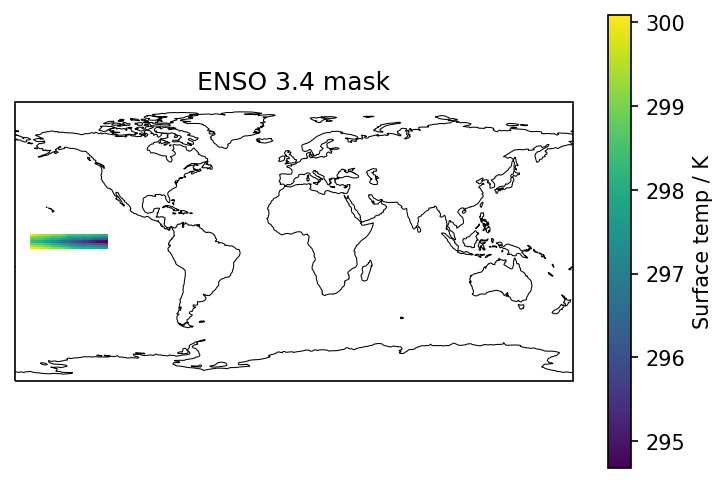

In [12]:
fig = plt.figure(dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
ax.coastlines(linewidth=0.5)

ch4_diff_cyclic, lon_plot = add_cyclic_point(enso34_by186[0,:,:], coord=lon_1)

plt.pcolormesh(lon_plot,lat_1,ch4_diff_cyclic)#, cmap='bwr', vmin = -1500, vmax = 1500)

plt.colorbar(label = 'Surface temp / K')
plt.title('ENSO 3.4 mask')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Average over ENSO3.4 area

In [14]:
temp_by186_lon_mean = np.mean(enso34_by186, axis = 2)
sst_34_by186 = np.average(temp_by186_lon_mean, weights = lat_area_scaled, axis = (1))

# temp_bo797_lon_mean = np.mean(enso34_bo797, axis = 2)
# sst_34_bo797 = np.average(temp_bo797_lon_mean, weights = lat_area_scaled, axis = (1))

Text(0.5, 1.0, 'ENSO3.4 temp')

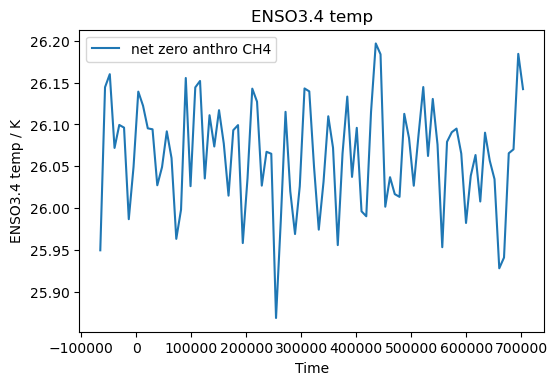

In [19]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(time_1[:90], sst_34_by186, label = 'net zero anthro CH4')
# ax.plot(dtime_2, sst_34_bo797, label = 'SSP370 INT')

plt.legend()
plt.xlabel('Time')
plt.ylabel(f'ENSO3.4 temp / K')
plt.title('ENSO3.4 temp')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

### Calculate 3 month running mean

In [20]:
N = 3
by186_3_mon_mean = np.convolve(sst_34_by186, np.ones((N,))/N, mode='valid')
# bo797_3_mon_mean = np.convolve(sst_34_bo797, np.ones((N,))/N, mode='valid')

## Calculate 30 year mean: bo797

In [13]:
#mean over lat and lon: SSP370, with area weighting
temp_ann_bo797_lon_mean = np.mean(enso34_bo797_ann, axis = 2)
sst_34_bo797_ann = np.average(temp_ann_bo797_lon_mean, weights = lat_area_scaled, axis = (1))

In [14]:
N2 = 360
temp_mean_30 = np.convolve(sst_34_bo797_ann, np.ones((N2,))/N2, mode='same')
date_mean_30 = np.convolve(time_3, np.ones((N2,))/N2, mode='same')

Text(0.5, 1.0, 'ENSO3.4 temp: u-bl593 and u-bo797')

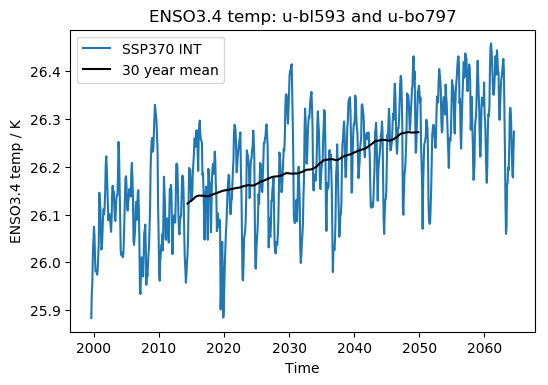

In [15]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(dtime_3, sst_34_bo797_ann, label = 'SSP370 INT')
ax.plot(dtime_3[180:-179], temp_mean_30[180:-179], c='k', label = '30 year mean')

plt.legend()
plt.xlabel('Time')
plt.ylabel(f'ENSO3.4 temp / K')
plt.title('ENSO3.4 temp: u-bl593 and u-bo797')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Calculate 30 year mean: bo797

In [21]:
#concatenate hist temp data with no anthro data for 2015 - 2050
concat_hist_by186 = np.concatenate((sst_34_bo797_ann[:180],sst_34_by186))

NameError: name 'sst_34_bo797_ann' is not defined

In [17]:
# 30 year mean
temp_mean_30_by186 = np.convolve(concat_hist_by186, np.ones((N2,))/N2, mode='same')

In [18]:
# calculate mean of 2020 - 2050 to use for last 15 years
temp_mean_by186_2035_2050 = np.mean(concat_hist_by186[-360:])
temp_array_2035_2050 = np.array([temp_mean_by186_2035_2050]*180)
#concatenate both 30 year mean arrays to get 2015 - 2050 range
temp_30_mean_concat = np.concatenate((temp_mean_30_by186[180:-179],temp_array_2035_2050))

Text(0.5, 1.0, 'ENSO3.4 temp: u-bl593 and u-by186')

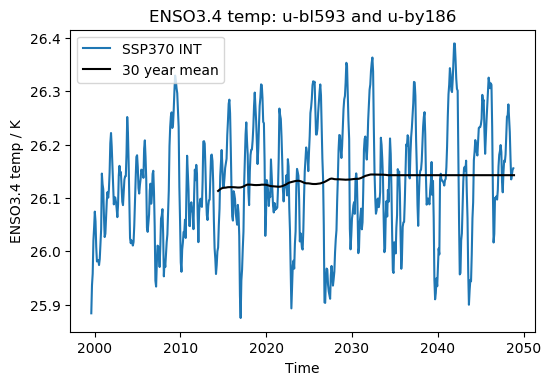

In [19]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(dtime_3[:600], concat_hist_by186, label = 'SSP370 INT')
ax.plot(dtime_3[180:-191], temp_30_mean_concat, c='k', label = '30 year mean') #temp_mean_30_by186[180:-179]

plt.legend()
plt.xlabel('Time')
plt.ylabel(f'ENSO3.4 temp / K')
plt.title('ENSO3.4 temp: u-bl593 and u-by186')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

## Calculate anomaly

In [20]:
temp_anomaly_by186 = by186_3_mon_mean - temp_30_mean_concat[1:-2]
temp_anomaly_bo797 = bo797_3_mon_mean - temp_mean_30[181:-181]

In [21]:
positive_by186 = np.array(temp_anomaly_by186) > 0
positive_bo797 = temp_anomaly_bo797 > 0

In [22]:
positive_by186 = pd.DataFrame(np.array(temp_anomaly_by186) > 0,
                   columns=['pos'])
positive_bo797 = pd.DataFrame(np.array(temp_anomaly_bo797) > 0,
                   columns=['pos'])

Text(0.5, 1.0, 'Temperature anomaly in ENSO3.4 region: no anthro CH4')

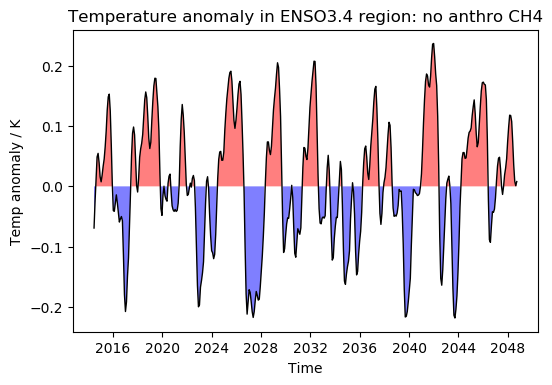

In [23]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(dtime_1[1:-1], temp_anomaly_by186, label = 'net zero anthro CH4', c = 'k', linewidth = 1)
ax.fill_between(dtime_1[1:-1], temp_anomaly_by186, 0 ,where=(temp_anomaly_by186 > 0), facecolor='red', alpha=0.5)
ax.fill_between(dtime_1[1:-1], temp_anomaly_by186, 0 ,where=(temp_anomaly_by186 < 0), facecolor='blue', alpha=0.5)

#plt.legend()
plt.xlabel('Time')
plt.ylabel(f'Temp anomaly / K')
plt.title('Temperature anomaly in ENSO3.4 region: no anthro CH4')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')

Text(0.5, 1.0, 'Temperature anomaly in ENSO3.4 region: SSP 370 INT')

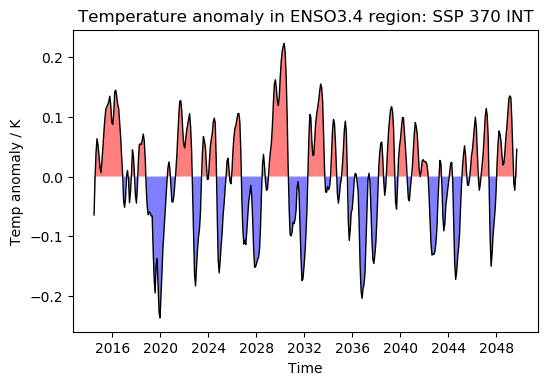

In [24]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(dtime_2[1:-1], temp_anomaly_bo797, label = 'SSP370 INT', c = 'k', linewidth = 1)#, s = 2, color=positive_bo797.pos.map({True: 'r', False: 'b'}))
ax.fill_between(dtime_2[1:-1], temp_anomaly_bo797, 0 ,where=(temp_anomaly_bo797 > 0), facecolor='red', alpha=0.5)
ax.fill_between(dtime_2[1:-1], temp_anomaly_bo797, 0 ,where=(temp_anomaly_bo797 < 0), facecolor='blue', alpha=0.5)

#plt.legend()
plt.xlabel('Time')
plt.ylabel(f'Temp anomaly / K')
plt.title('Temperature anomaly in ENSO3.4 region: SSP 370 INT')
#plt.savefig(f'{file_loc}ch4_grad_1985_2018.png')